# DataFusion between Accelerometer Model and Camera Model

In [2]:
#some set up
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import math
import time
from torchsummary import summary
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
class GestureFusionNet(nn.Module):
    def __init__(self, num_classes=11):
        super(GestureFusionNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Linear(22,15,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(15,11,bias=True),
            nn.ReLU(inplace=True)
            )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(11,self.num_classes,bias=True),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

In [15]:
model = GestureFusionNet()
print(model)

GestureFusionNet(
  (features): Sequential(
    (0): Linear(in_features=22, out_features=15, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=15, out_features=11, bias=True)
    (3): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=11, out_features=11, bias=True)
    (2): LogSoftmax(dim=1)
  )
)


In [16]:
summary(model,input_size=(1,22), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 15]             345
              ReLU-2                 [1, 1, 15]               0
            Linear-3                 [1, 1, 11]             176
              ReLU-4                 [1, 1, 11]               0
           Dropout-5                 [1, 1, 11]               0
            Linear-6                 [1, 1, 11]             132
        LogSoftmax-7                 [1, 1, 11]               0
Total params: 653
Trainable params: 653
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Load  Dataset

In [18]:
classes = ['0_pinch_index','10_palm_hold','1_palm_tilt','2_finger_slider','3_pinch_pinky','4_slow_swipe','5_fast_swipe','6_push','7_pull','8_finger_rub','9_circle']

In [38]:
dat1= np.loadtxt('fusiondataset/train/camdataset.csv',delimiter=",",dtype=np.float32,skiprows=1)
dat2= np.loadtxt('fusiondataset/train/adxldataset.csv',delimiter=",",dtype=np.float32,skiprows=1)
print(dat1[:,:11].shape)
print(dat2[:,:11].shape)
dat = np.concatenate((dat1[:,:11],dat2[:,:11]),axis=-1)
print(dat.shape)

(2200, 11)
(2200, 11)
(2200, 22)


In [45]:
from torch.utils.data import Dataset,DataLoader
class fusiondataset(Dataset):
    def __init__(self, data, target):
        dat1= np.loadtxt('fusiondataset/train/camdataset.csv',delimiter=",",dtype=np.float32,skiprows=1)
        dat2= np.loadtxt('fusiondataset/train/adxldataset.csv',delimiter=",",dtype=np.float32,skiprows=1)
        #print(dat1[:,:11].shape)
        #print(dat2[:,:11].shape)
        dat = np.concatenate((dat1[:,:11],dat2[:,:11]),axis=-1)
        #print(dat.shape)
        self.x_train = torch.from_numpy(dat)
        self.y_train = torch.from_numpy(dat2[:,[11]])
        self.n_samples = dat.shape[0]
    def __len__(self):
        return self.n_samples
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [46]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=1000)

In [47]:
dataset = fusiondataset(data,target)
valdataset = fusiondataset(data, target)

In [48]:
train_loader = DataLoader(dataset=dataset, batch_size=200, shuffle=True)
validate_loader = DataLoader(dataset=valdataset, batch_size=1, shuffle=True)

In [49]:
dataiter = iter(train_loader)
data = dataiter.next()
features, label = data
print(features, label)

tensor([[ 0.0000,  0.0000,  0.3108,  ..., -2.2438, -2.4823, -2.4700],
        [ 0.0000,  1.0522,  0.3553,  ..., -2.2438, -2.4823, -2.4700],
        [ 0.0000,  0.0000,  2.7838,  ..., -2.2404, -2.4746, -2.4597],
        ...,
        [ 0.0000,  0.0366,  0.1315,  ..., -2.2404, -2.4746, -2.4597],
        [ 0.0000,  0.0000,  0.4144,  ..., -2.2503, -2.4823, -2.4599],
        [ 0.0000,  0.0000,  0.3346,  ..., -2.2438, -2.4823, -2.4700]]) tensor([[ 7.],
        [ 1.],
        [ 2.],
        [ 9.],
        [ 8.],
        [ 6.],
        [ 6.],
        [ 7.],
        [ 9.],
        [ 5.],
        [ 0.],
        [ 8.],
        [10.],
        [ 9.],
        [ 9.],
        [ 7.],
        [ 2.],
        [ 5.],
        [ 7.],
        [ 5.],
        [ 0.],
        [ 5.],
        [ 8.],
        [10.],
        [ 8.],
        [ 8.],
        [ 4.],
        [ 4.],
        [ 2.],
        [ 2.],
        [ 4.],
        [ 9.],
        [ 2.],
        [ 4.],
        [ 8.],
        [ 0.],
        [ 4.],
        [ 6

### Training Neural Network

In [54]:
train_losses = []
accuracylist = []
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)
# Training  Model
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       train_loss = 0
       correct = 0
       # Iterate over data.
       for i,(inputs, labels) in enumerate(train_loader):
           # Forward Pass
           if (i+1) % 5 == 0:
               print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}')
           output = model(features)
           #print(torch.argmax(output,axis=1))
           #print(output)
           #print(torch.reshape(labels,(1,20))[0])
           #output1d = torch.argmax(output,axis=1)
           labels1d = torch.reshape(input=labels,shape=(1,200))[0]
           loss = criterion(output, labels1d.long())
           optimizer.zero_grad() # clear previous gradients
           loss.backward() # backward pass
           optimizer.step()
           train_loss += loss.item()
           #print(np.argmax(output.detach().numpy(),axis=1))
           #print(labels.detach().numpy())
           correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()
           print('{} Loss: {:.4f}'.format(
               'train', train_loss))
           train_losses.append(loss.item())
       accuracy = 100 * correct / len(dataset)
       accuracylist.append(accuracy)
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

2200 550


In [55]:
validate_losses = []
def validate_model(model, num_epochs=25):
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Evaluate
        # model.eval()
        #Initialize
        correct = 0
        # Iterate over data.
        for features, labels in validate_loader:
            output = model(features.float())
            correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()/len(dataset) *100
        validate_losses.append(correct)
        print('{} Acc: {:.4f}'.format(
            'Validate', correct))

In [56]:
# Define Hyper Parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [57]:
train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5143
train Loss: 5.0364
train Loss: 7.5972
train Loss: 10.1191
epoch 1/25, step 5/550, inputs torch.Size([200, 22])
train Loss: 12.6800
train Loss: 15.2188
train Loss: 17.6918
train Loss: 20.1727
train Loss: 22.7240
epoch 1/25, step 10/550, inputs torch.Size([200, 22])
train Loss: 25.2246
train Loss: 27.7002
Epoch 1/24
----------
train Loss: 2.4971
train Loss: 5.0486
train Loss: 7.5665
train Loss: 10.0609
epoch 2/25, step 5/550, inputs torch.Size([200, 22])
train Loss: 12.5783
train Loss: 15.0321
train Loss: 17.5219
train Loss: 20.0148
train Loss: 22.4582
epoch 2/25, step 10/550, inputs torch.Size([200, 22])
train Loss: 24.9595
train Loss: 27.4350
Epoch 2/24
----------
train Loss: 2.4456
train Loss: 4.9471
train Loss: 7.4170
train Loss: 9.8689
epoch 3/25, step 5/550, inputs torch.Size([200, 22])
train Loss: 12.3285
train Loss: 14.7877
train Loss: 17.2726
train Loss: 19.7536
train Loss: 22.1874
epoch 3/25, step 10/550, inputs torch.Size([200, 22])
tra

In [58]:
validate_model(model,num_epochs=25)

Epoch 0/24
----------
Validate Acc: 10.3636
Epoch 1/24
----------
Validate Acc: 10.7727
Epoch 2/24
----------
Validate Acc: 11.4545
Epoch 3/24
----------
Validate Acc: 10.7273
Epoch 4/24
----------
Validate Acc: 10.7727
Epoch 5/24
----------
Validate Acc: 11.3182
Epoch 6/24
----------
Validate Acc: 10.3182
Epoch 7/24
----------
Validate Acc: 11.0000
Epoch 8/24
----------
Validate Acc: 10.6818
Epoch 9/24
----------
Validate Acc: 10.6818
Epoch 10/24
----------
Validate Acc: 10.2273
Epoch 11/24
----------
Validate Acc: 10.8636
Epoch 12/24
----------
Validate Acc: 10.7273
Epoch 13/24
----------
Validate Acc: 10.4545
Epoch 14/24
----------
Validate Acc: 10.4091
Epoch 15/24
----------
Validate Acc: 10.9091
Epoch 16/24
----------
Validate Acc: 11.1818
Epoch 17/24
----------
Validate Acc: 11.5000
Epoch 18/24
----------
Validate Acc: 10.8182
Epoch 19/24
----------
Validate Acc: 11.6364
Epoch 20/24
----------
Validate Acc: 10.8182
Epoch 21/24
----------
Validate Acc: 10.1364
Epoch 22/24
--------

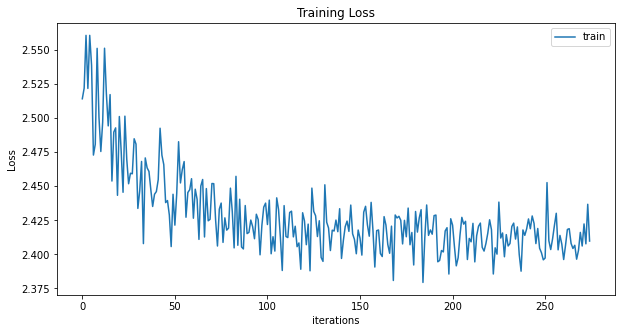

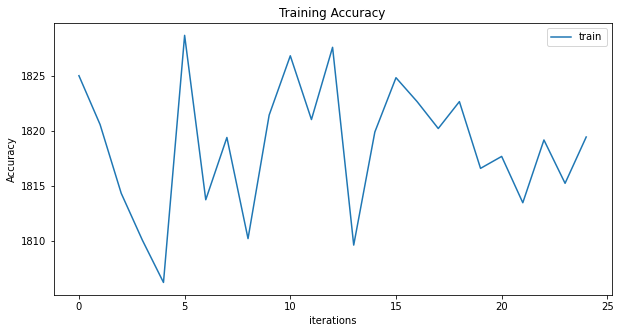

In [59]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(accuracylist,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

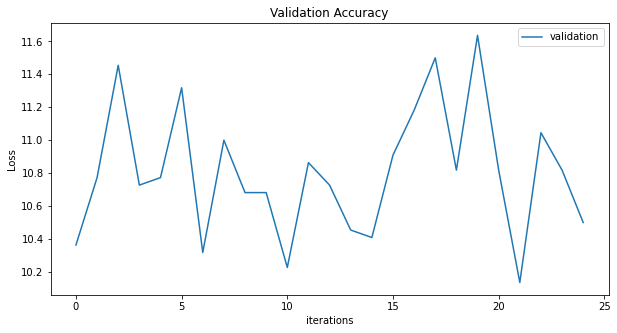

In [60]:
plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.plot(validate_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
torch.save(model.state_dict(), 'GestureFusionNet.pth')

### Calculate top-1 accuracy of the pre-trained model

## Test Model in Pytorch if the OpenCL implement is correct
By comprare the result of OpenCL implement and PyTorch implement using a single image as input  
error = ((OpenCL_implement_class_socores - PyTorch_implement_class_socores) ^ 2).sum(element_wise)  
If the OpenCL implement is correct, error should be relativly small.

In [62]:
# load the test image
dataiter = iter(validate_loader)
data = dataiter.next()
features, label = data
print(features, label)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0889,  0.0000,  0.0000,  0.0827,  0.0000,
          0.2042,  0.9053,  0.0000, -2.4354, -2.3757, -2.5684, -2.2928, -2.1506,
         -2.5363, -2.4902, -2.4168, -2.2438, -2.4823, -2.4700]]) tensor([[9.]])


In [147]:
model.cpu()
x_test = features
y_test = model(x_test.float())
print(y_test)
_, predicted = torch.max(y_test.data, 1)
print(predicted)
print('the label index prediction of pytorch implement: '+str(predicted))

tensor([[-2.2760, -2.2956, -2.4030, -2.6627, -2.4446, -2.2808, -2.6449, -2.3494,
         -2.2670, -2.2920, -2.5731]], grad_fn=<ViewBackward0>)
tensor([8])
the label index prediction of pytorch implement: tensor([8])


In [163]:
# Circle
xf_cam=[7.53542,6.16413,4.4144,4.2853,7.87615,3.54876,6.86316,7.75994,6.2377,6.609,12.5034]
xf_adxl = [-2.43538236618042,-2.3757214546203613,-2.568444013595581,-2.292815685272217,-2.1506237983703613,-2.5363268852233887,-2.4902496337890625,-2.416814088821411,-2.243840456008911,-2.482288360595703,-2.4699766635894775]
xf=np.concatenate((xf_cam,xf_adxl))
print(xf.shape)
xf=xf[np.newaxis,:]
xf= torch.from_numpy(xf)
model(xf.float())

(22,)


tensor([[-2.1806, -2.6862, -2.6195, -2.9565, -2.2370, -2.1039, -2.8574, -2.4503,
         -2.4781, -1.8457, -2.5283]], grad_fn=<ViewBackward0>)

In [164]:
# OpenCL setup
import pyopencl as cl
import deviceinfo

In [165]:
# Ask the user to select a platform/device on the CLI
context = cl.create_some_context()

# Print out device info
deviceinfo.output_device_info(context.devices[0])

# Create a command queue
queue = cl.CommandQueue(context)

Device is NVIDIA GeForce GTX 1650 TiGPU from NVIDIA Corporation with a max of 16 compute units


#### Step 2: import parameters from pytorch implement

In [166]:
params = model.state_dict()
for k,v in params.items():
    # print parameter name
    print(k,params[k].numpy().shape)
layer1_weight = params['features.0.weight'].numpy().reshape(-1)
layer1_bias = params['features.0.bias'].numpy()
layer2_weight = params['features.2.weight'].numpy().reshape(-1)
layer2_bias = params['features.2.bias'].numpy()
classifier_weight = params['classifier.1.weight'].numpy().reshape(-1)
classifier_bias = params['classifier.1.bias'].numpy()
print(len(layer1_bias))
print(len(layer2_bias))
print(len(classifier_bias))

features.0.weight (15, 22)
features.0.bias (15,)
features.2.weight (11, 15)
features.2.bias (11,)
classifier.1.weight (11, 11)
classifier.1.bias (11,)
15
11
11


In [167]:
print(params['features.0.weight'].numpy()[0].shape)
print(params['features.0.bias'].shape)

(22,)
torch.Size([15])


In [168]:
print(layer1_bias)

[-0.08581615  0.21964847 -0.10777292  0.00992819 -0.22319528  0.11712896
 -0.09502599 -0.0180279   0.00413159  0.089899   -0.18853663 -0.06026186
 -0.14539456 -0.12327883  0.15491678]


Create OpenCL memory object

In [170]:
h_sample = xf.float().numpy().reshape(-1)
h_result_layer1 = np.empty(1 * len(layer1_bias)).astype(np.float32)
h_result_layer2 = np.empty(1 * len(layer2_bias)).astype(np.float32)
h_result_classifier = np.empty(1 * len(classifier_bias)).astype(np.float32)

# device input buffer
d_sample = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_sample)

# device buffers 
d_layer1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer1_weight)
d_layer1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer1_bias)
d_layer2_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer2_weight)
d_layer2_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer2_bias)
d_classifier_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_weight)
d_classifier_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_bias)

d_result_layer1 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer1.nbytes)
d_result_layer2 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer2.nbytes)
d_result_classifier = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier.nbytes)

#### Step 3: create kernels
Create & build program

In [171]:
kernelSource = open("gesturenet.cl").read()
program = cl.Program(context, kernelSource).build(options="")

Create kernels

In [172]:
conv3x3 = program.conv2d3x3
conv3x3.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.int32, np.int32, \
                               None, None, None, None])

maxpool = program.maxpool2d
maxpool.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

conv1x1 = program.conv2d1x1
conv1x1.set_scalar_arg_dtypes([np.int32, np.int32, np.int32,\
                               None, None, None, None])

avgpool = program.avgpool2d
avgpool.set_scalar_arg_dtypes([np.int32,np.int32,None, None])

fc = program.fc
fc.set_scalar_arg_dtypes([np.int32,np.int32,None,None,None,None])

Run OpenCL implement  

In [173]:
import time
rtime = time.time()
# First
fc(queue,(len(layer1_bias),),None,len(h_sample),1,d_sample,d_layer1_weight,d_layer1_bias,d_result_layer1)
# Second
fc(queue,(len(layer2_bias),),None,len(layer1_bias),1,d_result_layer1,d_layer2_weight,d_layer2_bias,d_result_layer2)
# classifier
fc(queue,(len(classifier_bias),),None,len(layer2_bias),0,d_result_layer2,d_classifier_weight,d_classifier_bias,d_result_classifier)

queue.finish()
rtime = time.time() - rtime
print("The kernel ran in", rtime, "seconds")

The kernel ran in 0.0049877166748046875 seconds


In [174]:
z = model(xf.float())
z.detach().numpy().tolist()[0]

[-1.8493465185165405,
 -2.3097469806671143,
 -2.8168225288391113,
 -2.799983263015747,
 -2.2405295372009277,
 -2.3777267932891846,
 -2.9348278045654297,
 -2.676616668701172,
 -2.41953182220459,
 -2.06436824798584,
 -2.455657720565796]

In [175]:
#copy result from gpu
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
queue.finish()
label_opencl = np.argmax(h_result_classifier)
print('the label index prediction of OpenCL implement: %d' % label_opencl)
correct_result = z.data.numpy().reshape(-1)
print("Predicted Label:", str(np.argmax(z.detach().numpy())))
error = ((correct_result - h_result_classifier) ** 2).sum()
print('OpenCL implement error: ', error)
cl.enqueue_copy(queue, h_result_layer1, d_result_layer1)
print(h_result_layer1.shape)
cl.enqueue_copy(queue, h_result_layer2, d_result_layer2)
print(h_result_layer2.shape)
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
print(h_result_classifier.shape)
print(y_test.detach().numpy().tolist()[0])
print(h_result_classifier)

the label index prediction of OpenCL implement: 8
Predicted Label: 0
OpenCL implement error:  66.7579
(15,)
(11,)
(11,)
[-2.275974750518799, -2.295553684234619, -2.402991533279419, -2.6627485752105713, -2.444613218307495, -2.2807538509368896, -2.644904851913452, -2.3493869304656982, -2.267033576965332, -2.291966438293457, -2.5730643272399902]
[ 0.12593782 -0.21019289  0.01410684  0.286166    0.203709   -0.26232317
 -0.833421    0.3914472   0.50924486 -0.32969183 -0.20965008]


In [161]:
import math
total = 0
for i in range(0,len(h_result_classifier)):
    total += math.exp(h_result_classifier[i])
softlist = []
for j in range(0,len(h_result_classifier)):
    softlist.append(math.log(math.exp(h_result_classifier[j])/total))
print(softlist)
np.argmax(softlist)

[-2.227846563168437, -2.2919032278737137, -2.354013219781787, -2.5830887484630654, -2.4918218835523436, -2.366593398459823, -2.6446932706317017, -2.3410880270680496, -2.233863964982898, -2.375169873543651, -2.567630522259147]


0

In [176]:
# Layer 1
print(h_sample)
lay1out = []
for i in range(0,len(layer1_bias)):
    tmp = layer1_bias[i]
    for j in range(0, len(h_sample)):
        tmp = tmp + h_sample[j]*layer1_weight[i*len(h_sample)+j]
        #print(j, h_sample[j], layer1_weight[i*len(h_sample)+j], tmp)
    if tmp > 0:
        lay1out.append(tmp)
    else:
        lay1out.append(0)
print(len(lay1out))
print(lay1out)
# Layer 2
lay2out = []
for i in range(0,len(layer2_bias)):
    tmp = layer2_bias[i]
    for j in range(0, len(lay1out)):
        tmp = tmp + lay1out[j]*layer2_weight[i*len(lay1out)+j]
    if tmp > 0:
        lay2out.append(tmp)
    else:
        lay2out.append(0)
print(len(lay2out))
print(lay2out)
# Layer 4
lay4out = []
for i in range(0,len(classifier_bias)):
    tmp = classifier_bias[i]
    for j in range(0, len(lay2out)):
        tmp = tmp + lay2out[j]*classifier_weight[i*len(lay2out)+j]
    lay4out.append(tmp)
print(len(lay4out))
print(lay4out)
# softmax
import math
total = 0
for i in range(0,len(classifier_bias)):
    total += math.exp(lay4out[i])
softlist = []
for j in range(0,len(classifier_bias)):
    softlist.append(math.log(math.exp(lay4out[j])/total))
print(softlist)
np.argmax(softlist)

[ 7.53542    6.16413    4.4144     4.2853     7.87615    3.54876
  6.86316    7.75994    6.2377     6.609     12.5034    -2.4353824
 -2.3757215 -2.568444  -2.2928157 -2.1506238 -2.536327  -2.4902496
 -2.416814  -2.2438405 -2.4822884 -2.4699767]
15
[0, 4.6666365, 0, 0, 0.07350059, 0, 0, 3.4917524, 0, 1.3498858, 0, 0, 1.602461, 2.7651904, 0]
11
[0, 0, 0.8783022509887815, 0.6575995068997145, 0.8723443802446127, 1.9955746131017804, 0, 0, 0, 0, 0]
11
[0.12593777960703917, -0.2101928896066153, 0.014106844138196767, 0.2861660664203995, 0.20370904059624811, -0.2623231991745858, -0.8334209821364852, 0.3914472074148263, 0.5092449281041195, -0.3296918674699363, -0.2096500970825074]
[-2.307069341811343, -2.6432000110249976, -2.4189002772801858, -2.146841054997983, -2.2292980808221343, -2.6953303205929684, -3.2664281035548677, -2.0415599140035563, -1.923762193314263, -2.7626989888883187, -2.6426572185008896]


8

In [120]:
print(h_result_layer1)

[0.         0.76522785 0.         0.         1.0909626  0.
 0.         0.9141611  0.         0.99507725 0.         0.3914182
 0.0225848  0.         0.8346449 ]


In [81]:
print(h_result_layer2)

[0.         0.23640126 0.06758584 0.14773476 0.06684428 0.10578736
 0.         0.         0.         0.         0.        ]


In [83]:
print(h_result_classifier)

[ 0.24508141  0.15116419  0.11261825 -0.14547957 -0.04872648  0.09839498
 -0.16657802  0.10574111  0.2031898   0.10887353 -0.10496421]


# Export Weights

In [85]:
with open('gesture_fusion_weights.h', 'w') as testfile:
    testfile.write('//Layer1 Weights \n')
    testfile.write('float flayer1_weight[] = {\n')
    for wx in range(0,len(layer1_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(layer1_weight)-1:
            testfile.write(str(layer1_weight[wx])+'f')
        else:
            testfile.write(str(layer1_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float flayer1_bias[] = {\n')
    for rx in range(0,len(layer1_bias)):
        if rx != len(layer1_bias)-1:
            testfile.write(str(layer1_bias[rx])+'f,')
        else:
            testfile.write(str(layer1_bias[rx])+'f')
    testfile.write('};\n')
    
    testfile.write('//Layer2 Weights \n')
    testfile.write('float flayer2_weight[] = {\n')
    for wx in range(0,len(layer2_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(layer2_weight)-1:
            testfile.write(str(layer2_weight[wx])+'f')
        else:
            testfile.write(str(layer2_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float flayer2_bias[] = {\n')
    for rx in range(0,len(layer2_bias)):
        if rx != len(layer2_bias)-1:
            testfile.write(str(layer2_bias[rx])+'f,')
        else:
            testfile.write(str(layer2_bias[rx])+'f')
    testfile.write('};\n')
    
    testfile.write('//Classifier Weights \n')
    testfile.write('float fclassifier_weight[] = {\n')
    for wx in range(0,len(classifier_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(classifier_weight)-1:
            testfile.write(str(classifier_weight[wx])+'f')
        else:
            testfile.write(str(classifier_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float fclassifier_bias[] = {\n')
    for rx in range(0,len(classifier_bias)):
        if rx != len(classifier_bias)-1:
            testfile.write(str(classifier_bias[rx])+'f,')
        else:
            testfile.write(str(classifier_bias[rx])+'f')
    testfile.write('};\n')
    